In [1]:
from datasets import load_dataset
# dset = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")
dset = load_dataset("kresnik/librispeech_asr_test", "clean")['test'].shuffle().select(list(range(200)))
dset = dset.remove_columns(['speaker_id', 'chapter_id','id'])
print(dset)

import numpy as np
from datasets import load_metric
wer_metric = load_metric("wer")

Reusing dataset librispeech_asr (/home-nfs/goutham/.cache/huggingface/datasets/kresnik___librispeech_asr/clean/2.1.0/16bc288fa237b20821c5b51c8c09426b2689d8c5a889287589cb12aba6705e74)


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['file', 'audio', 'text'],
    num_rows: 200
})


In [2]:
import torch
from transformers import Wav2Vec2Processor
from custom_mult_wav2vec2 import Wav2Vec2ForCTC

w2v_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
w2v_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").cuda()

def layer_noisy_decoding(batch, noise_layer, noise):
    speech = batch["audio"]["array"]
    input_values = w2v_processor(speech, sampling_rate=16000, return_tensors="pt", padding="longest").input_values
    input_values = input_values.to("cuda")
    if noise_layer == -1: # No noise
        logits = w2v_model(input_values).logits
    else:
        logits = w2v_model(input_values, noise_layer = noise_layer, noise = noise).logits
    pred_ids = torch.argmax(logits, dim=-1)
    batch["pred_str"] = w2v_processor.batch_decode(pred_ids)[0]
    return batch

noises = np.arange(0, .65, .1)
layers = list(range(-1, 13, 1))
vals = []
for noise in noises:
    vals.append([])
    for layer in layers:
        new_dset = dset.map(layer_noisy_decoding, 
                            fn_kwargs = {"noise": noise, "noise_layer": layer}, 
                            batch_size = 1,
                            load_from_cache_file=False)
        wer = wer_metric.compute(predictions=new_dset["pred_str"], references=new_dset["text"])
        vals[-1].append(np.round(wer, 2))
        print("Noise: {}, Layer: {}, Test WER: {:.3f}".format(noise, layer, wer))
    print(vals)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Parameter 'function'=<function layer_noisy_decoding at 0x7f47c5321990> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: -1, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 0, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 1, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 2, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 3, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 4, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 5, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 6, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 7, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 8, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 9, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 10, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 11, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 12, Test WER: 0.034
[[0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]]


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: -1, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 0, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 1, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 2, Test WER: 0.036


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 3, Test WER: 0.035


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 4, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 5, Test WER: 0.035


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 6, Test WER: 0.035


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 7, Test WER: 0.033


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 8, Test WER: 0.035


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 9, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 10, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 11, Test WER: 0.035


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 12, Test WER: 0.035
[[0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03], [0.03, 0.03, 0.03, 0.04, 0.04, 0.03, 0.03, 0.04, 0.03, 0.03, 0.03, 0.03, 0.04, 0.03]]


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: -1, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 0, Test WER: 0.035


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 1, Test WER: 0.035


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 2, Test WER: 0.035


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 3, Test WER: 0.035


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 4, Test WER: 0.036


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 5, Test WER: 0.035


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 6, Test WER: 0.035


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 7, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 8, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 9, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 11, Test WER: 0.052


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 12, Test WER: 0.034
[[0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03], [0.03, 0.03, 0.03, 0.04, 0.04, 0.03, 0.03, 0.04, 0.03, 0.03, 0.03, 0.03, 0.04, 0.03], [0.03, 0.04, 0.03, 0.03, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03, 0.04, 0.05, 0.03]]


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: -1, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 0, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 1, Test WER: 0.036


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 2, Test WER: 0.035


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 3, Test WER: 0.037


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 4, Test WER: 0.036


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 5, Test WER: 0.038


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 6, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 7, Test WER: 0.041


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 8, Test WER: 0.036


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 9, Test WER: 0.041


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 10, Test WER: 0.046


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 11, Test WER: 0.252


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 12, Test WER: 0.034
[[0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03], [0.03, 0.03, 0.03, 0.04, 0.04, 0.03, 0.03, 0.04, 0.03, 0.03, 0.03, 0.03, 0.04, 0.03], [0.03, 0.04, 0.03, 0.03, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03, 0.04, 0.05, 0.03], [0.03, 0.03, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.05, 0.25, 0.03]]


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: -1, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 0, Test WER: 0.035


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 1, Test WER: 0.038


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 2, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 3, Test WER: 0.040


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 4, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 5, Test WER: 0.044


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 6, Test WER: 0.044


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 7, Test WER: 0.044


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 8, Test WER: 0.050


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 9, Test WER: 0.060


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 10, Test WER: 0.088


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 11, Test WER: 0.735


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 12, Test WER: 0.035
[[0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03], [0.03, 0.03, 0.03, 0.04, 0.04, 0.03, 0.03, 0.04, 0.03, 0.03, 0.03, 0.03, 0.04, 0.03], [0.03, 0.04, 0.03, 0.03, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03, 0.04, 0.05, 0.03], [0.03, 0.03, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.05, 0.25, 0.03], [0.03, 0.03, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.05, 0.06, 0.09, 0.73, 0.03]]


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: -1, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 0, Test WER: 0.038


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 1, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 2, Test WER: 0.046


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 3, Test WER: 0.052


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 4, Test WER: 0.061


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 5, Test WER: 0.056


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 6, Test WER: 0.064


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 7, Test WER: 0.067


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 8, Test WER: 0.079


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 9, Test WER: 0.136


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 10, Test WER: 0.170


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 11, Test WER: 0.944


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 12, Test WER: 0.035
[[0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03], [0.03, 0.03, 0.03, 0.04, 0.04, 0.03, 0.03, 0.04, 0.03, 0.03, 0.03, 0.03, 0.04, 0.03], [0.03, 0.04, 0.03, 0.03, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03, 0.04, 0.05, 0.03], [0.03, 0.03, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.05, 0.25, 0.03], [0.03, 0.03, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.05, 0.06, 0.09, 0.73, 0.03], [0.03, 0.04, 0.04, 0.05, 0.05, 0.06, 0.06, 0.06, 0.07, 0.08, 0.14, 0.17, 0.94, 0.04]]


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: -1, Test WER: 0.034


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 0, Test WER: 0.036


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 1, Test WER: 0.048


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 2, Test WER: 0.059


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 3, Test WER: 0.085


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 4, Test WER: 0.093


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 5, Test WER: 0.104


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 6, Test WER: 0.105


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 7, Test WER: 0.119


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 8, Test WER: 0.181


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 9, Test WER: 0.290


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 10, Test WER: 0.315


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 12, Test WER: 0.036
[[0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03], [0.03, 0.03, 0.03, 0.04, 0.04, 0.03, 0.03, 0.04, 0.03, 0.03, 0.03, 0.03, 0.04, 0.03], [0.03, 0.04, 0.03, 0.03, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03, 0.04, 0.05, 0.03], [0.03, 0.03, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.05, 0.25, 0.03], [0.03, 0.03, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.05, 0.06, 0.09, 0.73, 0.03], [0.03, 0.04, 0.04, 0.05, 0.05, 0.06, 0.06, 0.06, 0.07, 0.08, 0.14, 0.17, 0.94, 0.04], [0.03, 0.04, 0.05, 0.06, 0.08, 0.09, 0.1, 0.11, 0.12, 0.18, 0.29, 0.31, 0.98, 0.04]]


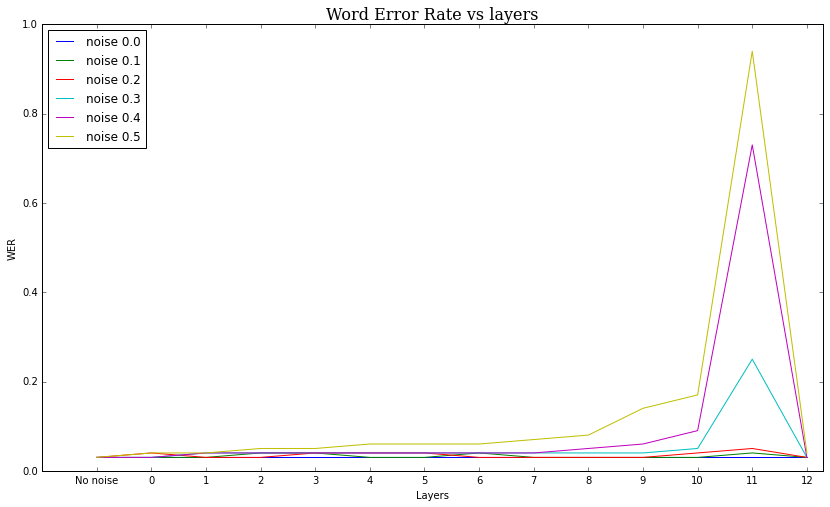

In [3]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

fig = plt.figure(figsize=(14, 8))

for i, cur in enumerate(vals[:-1]):
    plt.plot(layers, cur, alpha=1, label="noise {}".format(np.round(noises[i], 2)))
plt.legend(loc = 'upper left')
plt.xticks(layers + [12.3], ["No noise"] + [str(x) for x in layers[1:]] + [''])
plt.xlabel("Layers")
plt.ylabel("WER")
plt.title("Word Error Rate vs layers", fontsize=16, family='serif')
plt.savefig('mult_wer_vs_layers.pdf')
plt.show()

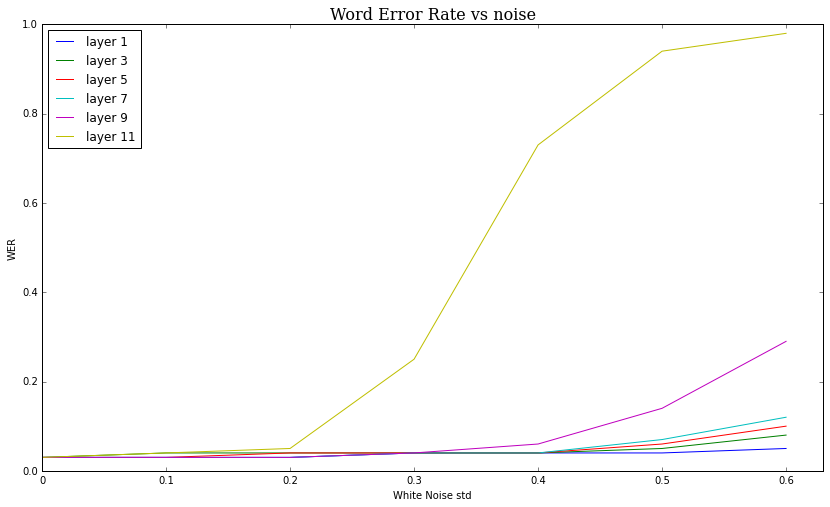

In [9]:
fig = plt.figure(figsize=(14, 8))

vals_T = np.array(vals).T

layer = -1
for i, cur in enumerate(vals_T):
    if i == 0 or i % 2 == 1:
        continue
    plt.plot(noises, cur, alpha=1, label="layer {}".format(layers[i]))
xtix = [0, .1, .2, .3, .4, .5, .6]
plt.xticks(xtix + [.63], [str(x) for x in xtix] + [''])
plt.legend(loc = 'upper left')
plt.xlabel("White Noise std")
plt.ylabel("WER")
plt.title("Word Error Rate vs noise", fontsize=16, family='serif')
plt.savefig('mult_wer_vs_noise.pdf')
plt.show()